# Given a Bank customer, can we build a classifier that can determine whether they will leave or not using Neural networks?

**The points distribution for this case is as follows: Read the dataset**

**Read the dataset**
* Drop the columns which are unique for all users like IDs (2.5 points)
* Distinguish the feature and target set (2.5 points)
* Divide the data set into train and test sets
Normalize the train and test data (2.5 points)
* Initialize & build the model (10 points)
* Optimize the model (5 points)
* Predict the results using 0.5 as a threshold (5 points)

**Print the Accuracy score and confusion matrix (2.5 points)**


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [3]:
import tensorflow as tf
print(tf.__version__)

2.1.0-rc1


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the dataset

In [5]:
df = pd.read_csv("/content/drive/My Drive/Colab/bank.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**Exploratory Data Analysis**

In [6]:
df.shape

(10000, 14)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [8]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [9]:
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

# Drop the columns which are unique for all users like IDs (2.5 points)

CustomerId,RowNumber,Surname to be unique for each users, so dropping them respectively

In [0]:
df =df.drop(["CustomerId","RowNumber","Surname"] , axis=1)

In [11]:
df.shape

(10000, 11)

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


Most of the attributes are normally distributed, Now lets look at the outliers

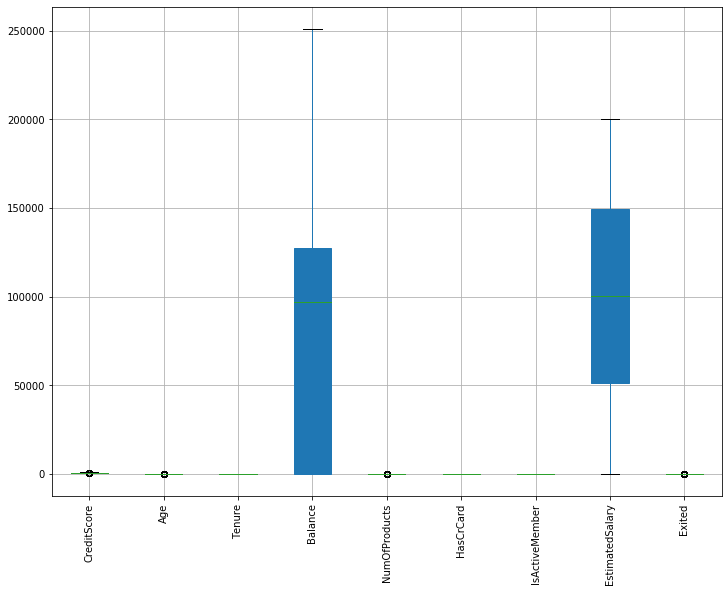

In [13]:
plt.figure(figsize=(12,9))
bplot = df.boxplot(patch_artist=True)
plt.xticks(rotation=90)       
plt.show()

There are few outliers in CreditScore, Age, Numofproducts and Exited columns 

**Treating Outliers**

In [0]:
def remove_outlier(feature):
    ##  This method takes feature as input and treats their IQR upper and lower outliers by assigning them to max and min
    first_q = np.percentile(df[feature], 25)
    third_q = np.percentile(df[feature], 75) 
    IQR = third_q - first_q
    IQR *= 1.5
    minimum = first_q - IQR 
    maximum = third_q + IQR

    #mean = df[feature].median()
    
    df.loc[df[feature] < minimum, feature] = minimum
    df.loc[df[feature] > maximum, feature] = maximum

In [0]:
outliers = ["CreditScore"]

for i in range(len(outliers)):
    remove_outlier(outliers[i])

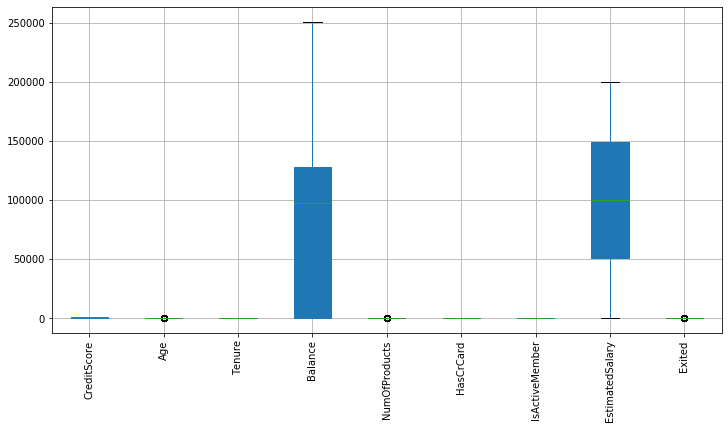

In [16]:
plt.figure(figsize=(12,6))
bplot = df.boxplot(patch_artist=True)
plt.xticks(rotation=90)       
plt.show()

The CreditScore outlier is treated now

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


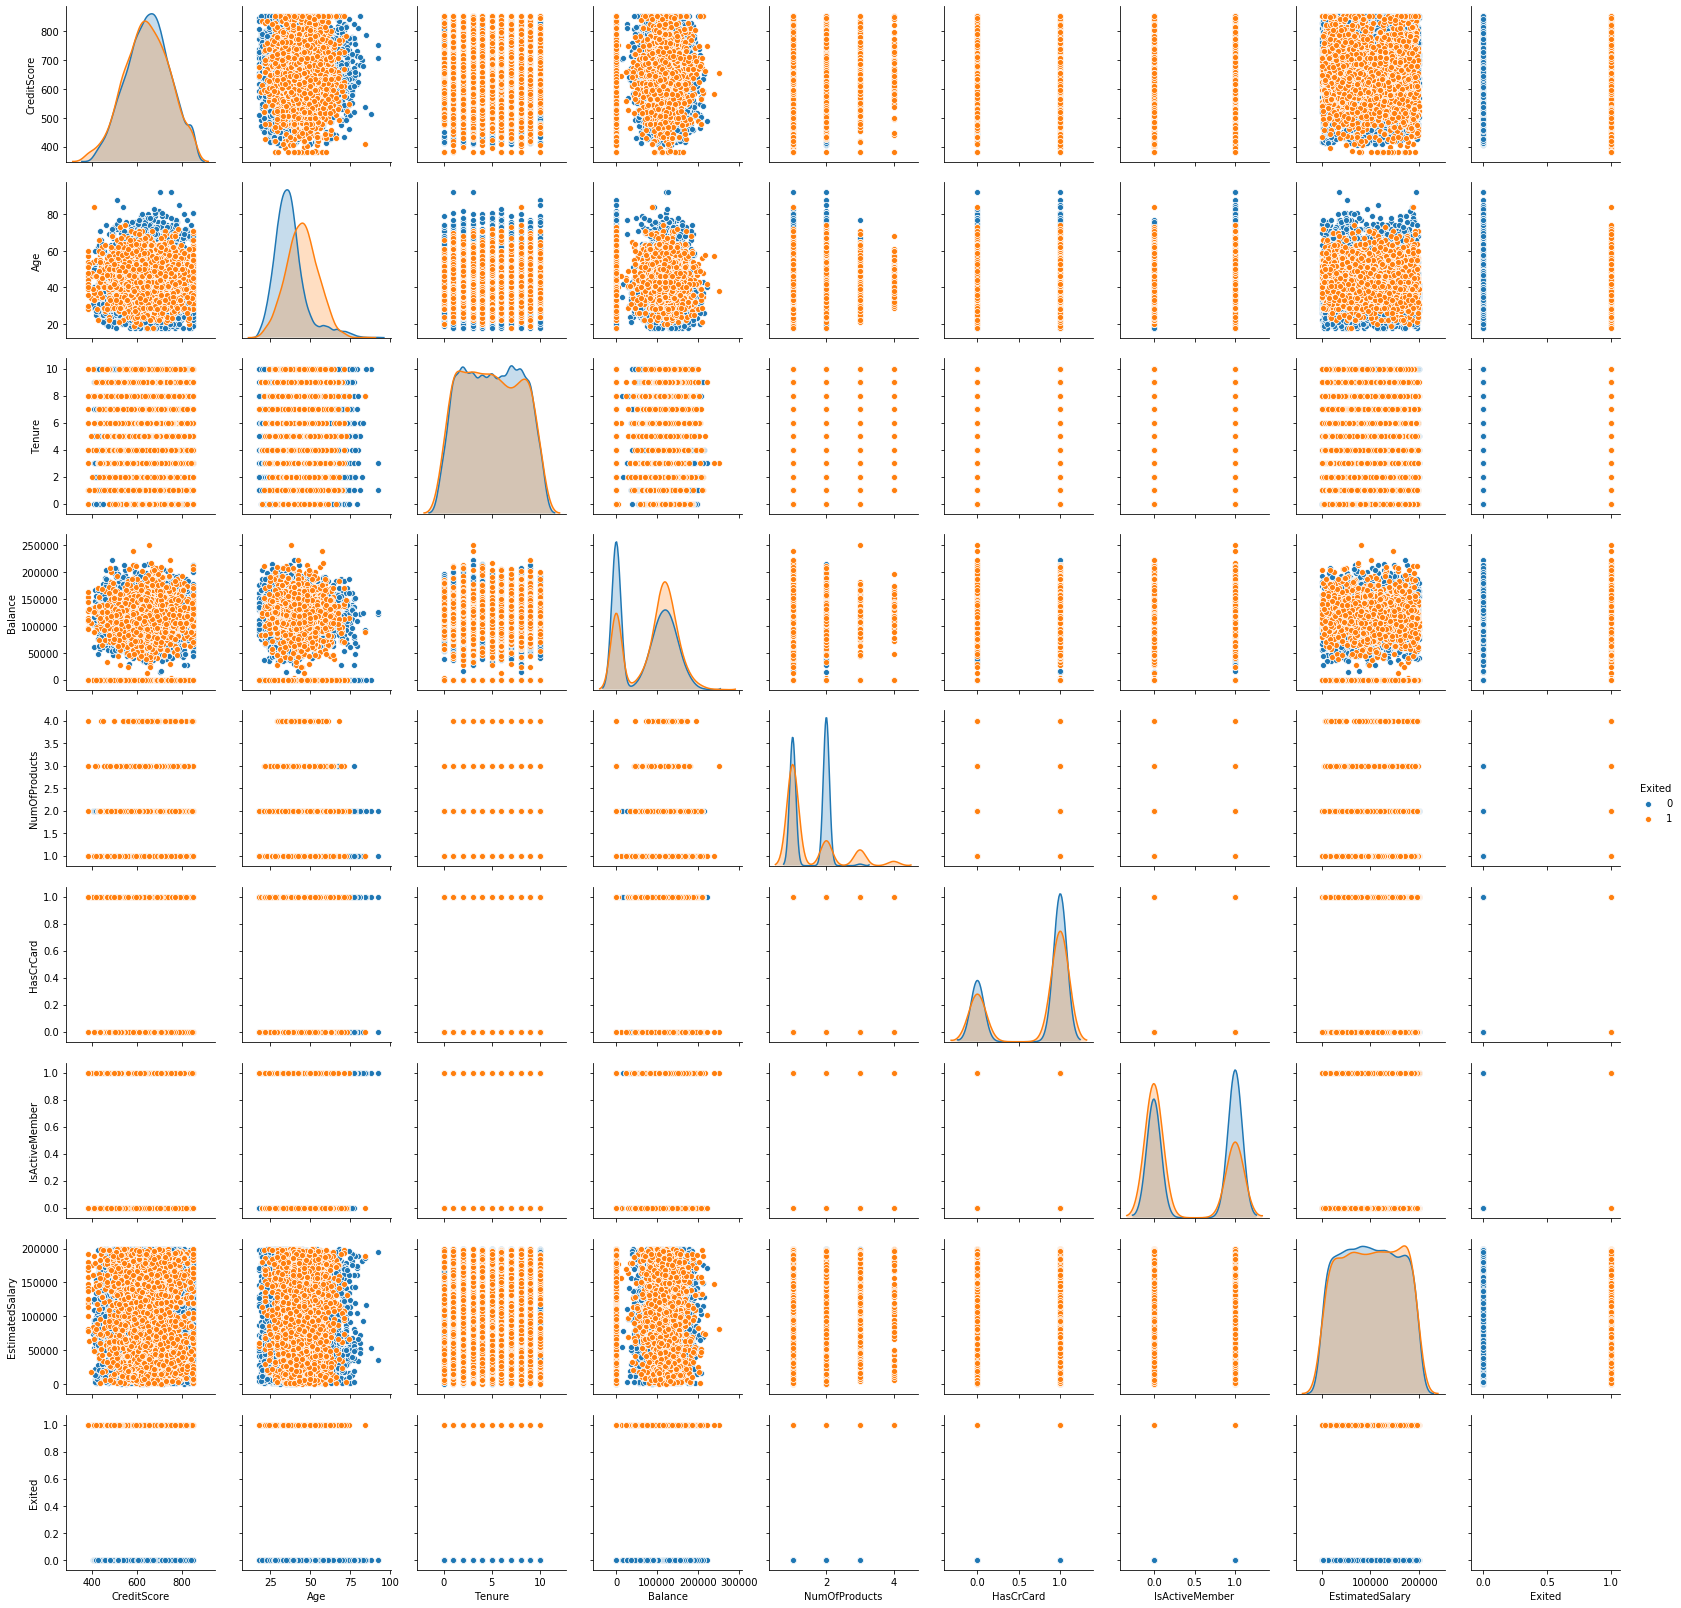

In [17]:
sns.pairplot(df, diag_kind='kde',hue ='Exited' )

**Co-relation Heatmap:**

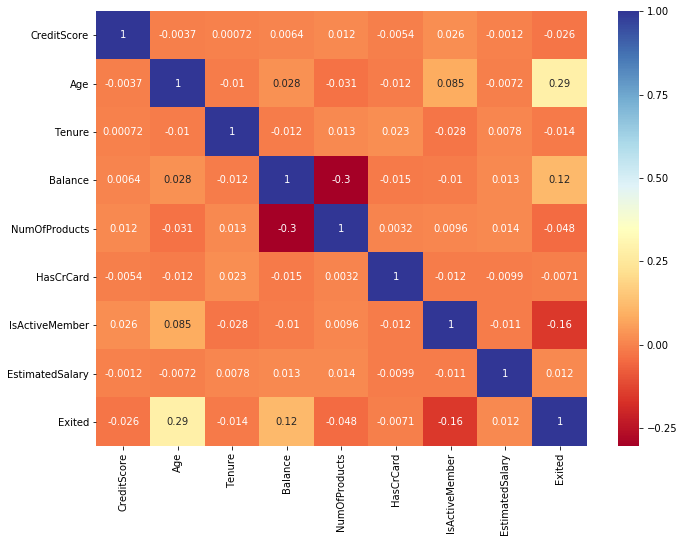

In [18]:
plt.subplots(figsize=(11,8))
sns.heatmap(df.corr(), annot=True, cmap="RdYlBu")
plt.show()

There is no co-linearity between independent attributes

**Our target is the Exit status so lets see how the given attributes are related to the target variable**

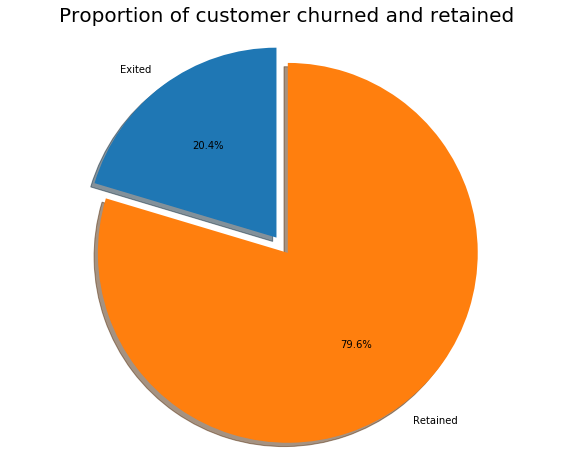

In [19]:
labels = 'Exited', 'Retained'
sizes = [df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained", size = 20)
plt.show()

So about 20.4% of the customers have churned and retained. We need to ensure that the chosen model does predict with great accuracy for this 20.4% as it is of interest to the bank to identify and keep this bunch as opposed to accurately predicting the customers that are retained.

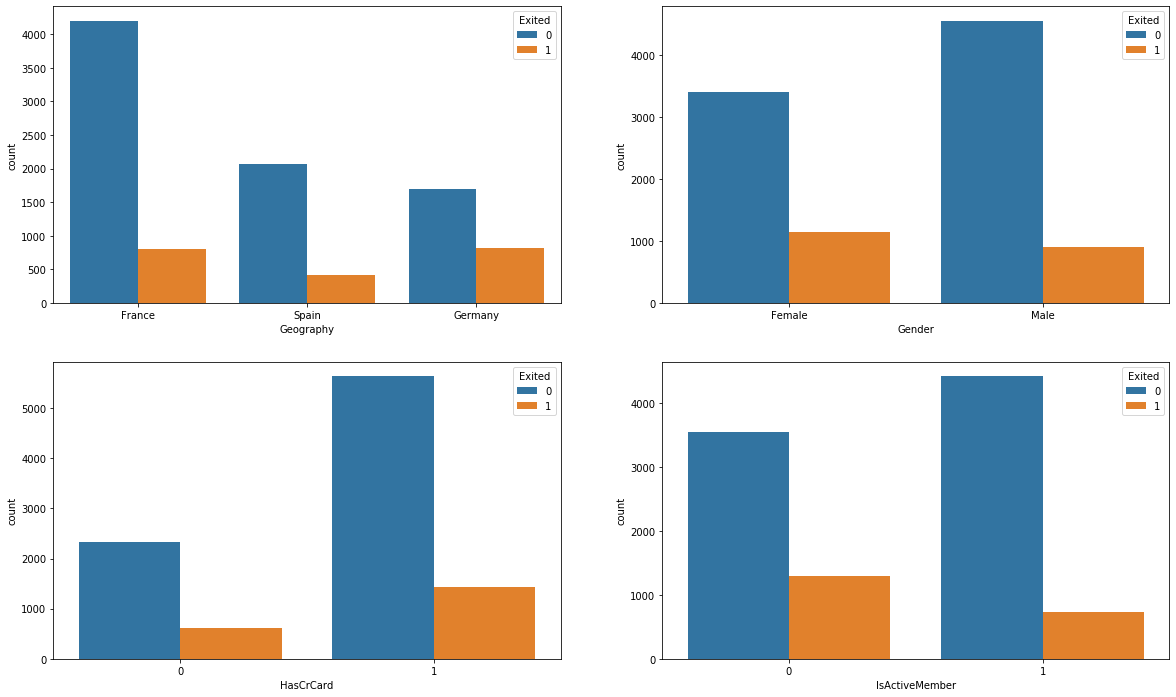

In [20]:
# We first review the 'Status' relation with categorical variables
    fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
    sns.countplot(x='Geography', hue = 'Exited',data = df, ax=axarr[0][0])
    sns.countplot(x='Gender', hue = 'Exited',data = df, ax=axarr[0][1])
    sns.countplot(x='HasCrCard', hue = 'Exited',data = df, ax=axarr[1][0])
    sns.countplot(x='IsActiveMember', hue = 'Exited',data = df, ax=axarr[1][1])

# Inference:

* Majority of the data is of people from France.
* The proportion of female customers churning is greater than that of male customers
* Most of the customers that churned are those with credit cards.
* Inactive members have a high churn rate 

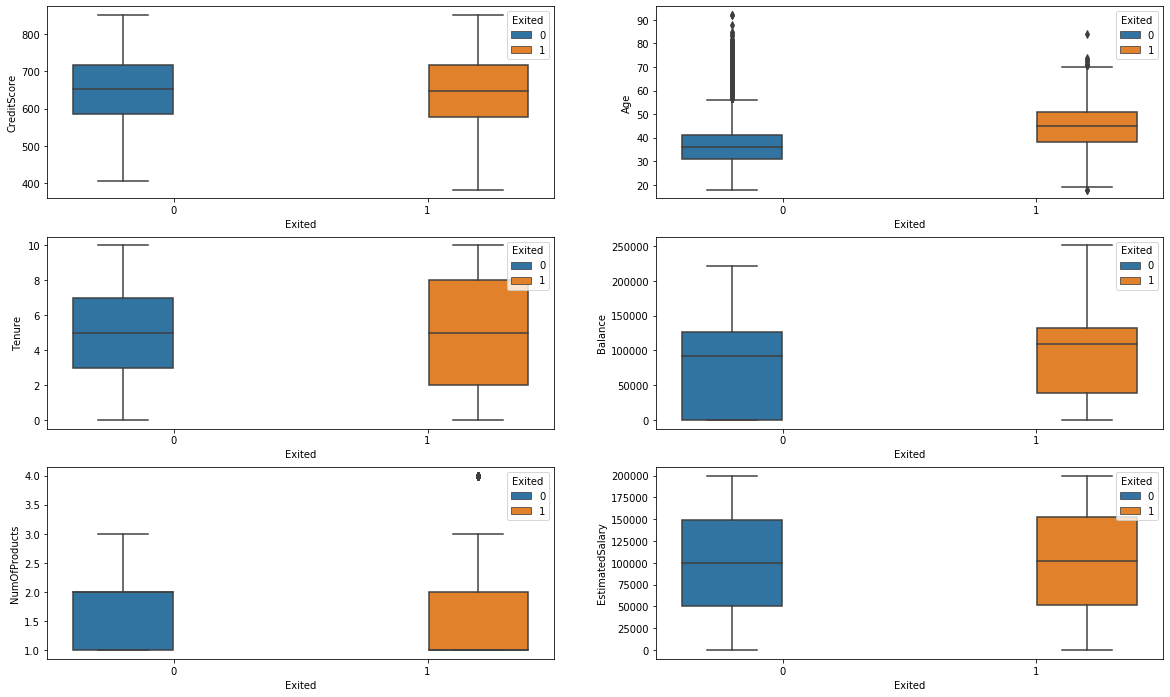

In [21]:
# Relations based on the continuous data attributes
    fig, axarr = plt.subplots(3, 2, figsize=(20, 12))
    sns.boxplot(y='CreditScore',x = 'Exited', hue = 'Exited',data = df, ax=axarr[0][0])
    sns.boxplot(y='Age',x = 'Exited', hue = 'Exited',data = df , ax=axarr[0][1])
    sns.boxplot(y='Tenure',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][0])
    sns.boxplot(y='Balance',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][1])
    sns.boxplot(y='NumOfProducts',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][0])
    sns.boxplot(y='EstimatedSalary',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][1])

# Inference:

* There is no difference in the credit score of retained and churned customers.
* The older customers are churning more than the young customers.
* With respect to tenure ,customers who have spent very little or very high time(The two extremes)have churned more.
* Salary and no of products doesn't have much impact on the churning ratio.
* The customers with high balances are churning more.

**Encoding Geography and Gender categorical attributes**

In [22]:
Geography= pd.get_dummies(prefix='Geo',data=df,columns=['Geography'])
Geography.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geo_France,Geo_Germany,Geo_Spain
0,619.0,Female,42,2,0.00,1,1,1,101348.88,1,1,0,0
1,608.0,Female,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,502.0,Female,42,8,159660.80,3,1,0,113931.57,1,1,0,0
3,699.0,Female,39,1,0.00,2,0,0,93826.63,0,1,0,0
4,850.0,Female,43,2,125510.82,1,1,1,79084.10,0,0,0,1


In [23]:
Gender = Geography.replace(to_replace={'Gender': {'Female': 1,'Male':0}})
Gender.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geo_France,Geo_Germany,Geo_Spain
0,619.0,1,42,2,0.00,1,1,1,101348.88,1,1,0,0
1,608.0,1,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,502.0,1,42,8,159660.80,3,1,0,113931.57,1,1,0,0
3,699.0,1,39,1,0.00,2,0,0,93826.63,0,1,0,0
4,850.0,1,43,2,125510.82,1,1,1,79084.10,0,0,0,1


In [0]:
churn_data = Gender

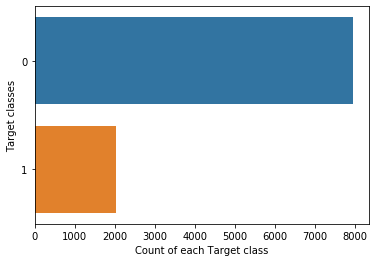

In [25]:
sns.countplot(y=churn_data.Exited ,data=churn_data)
plt.xlabel("Count of each Target class")
plt.ylabel("Target classes")
plt.show()

The data is biased towards the retained customers

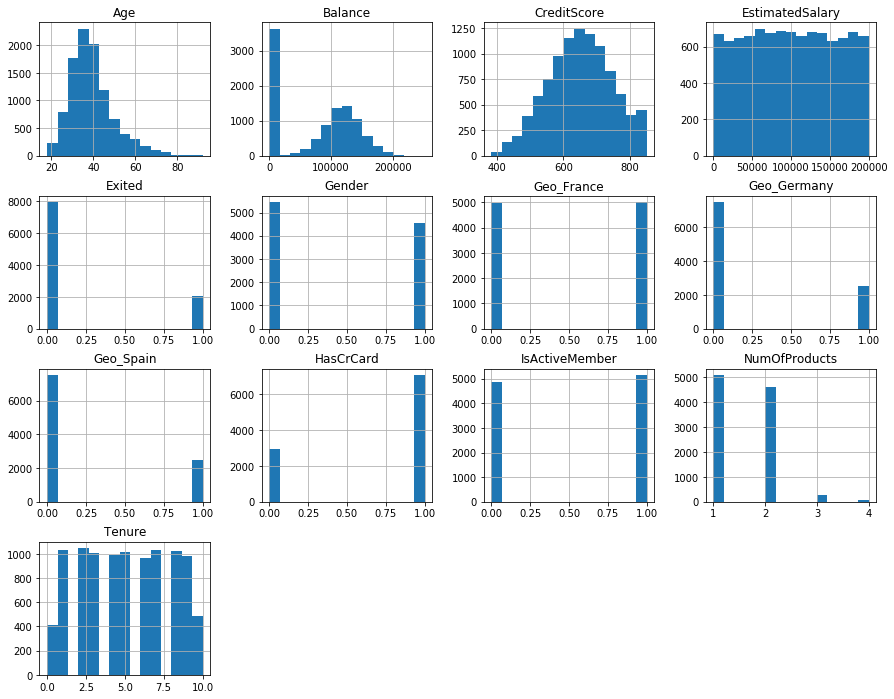

In [26]:
churn_data.hist(figsize=(15,12),bins = 15)
plt.title("Features Distribution")
plt.show()

# Distinguish the feature and target set (2.5 points)

In [0]:
X = churn_data.drop(['Exited'],axis=1)
y = churn_data.Exited

In [28]:
X.head(10)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geo_France,Geo_Germany,Geo_Spain
0,619.0,1,42,2,0.00,1,1,1,101348.88,1,0,0
1,608.0,1,41,1,83807.86,1,0,1,112542.58,0,0,1
2,502.0,1,42,8,159660.80,3,1,0,113931.57,1,0,0
3,699.0,1,39,1,0.00,2,0,0,93826.63,1,0,0
4,850.0,1,43,2,125510.82,1,1,1,79084.10,0,0,1
5,645.0,0,44,8,113755.78,2,1,0,149756.71,0,0,1
6,822.0,0,50,7,0.00,2,1,1,10062.80,1,0,0
7,383.0,1,29,4,115046.74,4,1,0,119346.88,0,1,0
8,501.0,0,44,4,142051.07,2,0,1,74940.50,1,0,0
9,684.0,0,27,2,134603.88,1,1,1,71725.73,1,0,0


# Divide the data set into train and test sets

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 0)

# Normalize the train and test data (2.5 points)

In [0]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Initialize & build the model (10 points)

In [0]:
classifier = tf.keras.models.Sequential()
# Adding the input layer and the first hidden layer
classifier.add(tf.keras.layers.Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 12))

# Adding the second hidden layer
classifier.add(tf.keras.layers.Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(tf.keras.layers.Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN | means applying SGD on the whole ANN
classifier.compile(optimizer = 'sgd', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [32]:
# Fitting the ANN to the Training set
classifier.fit(X_train, y_train, batch_size = 10, epochs = 100,verbose = 0,validation_data=(X_test, y_test))

In [33]:
score, acc = classifier.evaluate(X_train, y_train, batch_size=10)
print('Train accuracy:', acc)
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

print('-'*100)

score, acc = classifier.evaluate(X_test, y_test, batch_size=10)
print('Test accuracy:', acc)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

7000/7000 [==============================] - 1s 108us/sample - loss: 0.3338 - accuracy: 0.8637
Train accuracy: 0.8637143
----------------------------------------------------------------------------------------------------
3000/3000 [==============================] - 0s 105us/sample - loss: 0.3343 - accuracy: 0.8637
Test accuracy: 0.86366665


ANN model with 2 hidden layers have yielded a accuracy score of 85%

In [34]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 78        
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 7         
Total params: 127
Trainable params: 127
Non-trainable params: 0
_________________________________________________________________


**Confusion matrix:**

In [35]:
print("Confusion Matrix :", "\n",cm )

Confusion Matrix : 
 [[2293   86]
 [ 323  298]]


In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2379
           1       0.78      0.48      0.59       621

    accuracy                           0.86      3000
   macro avg       0.83      0.72      0.76      3000
weighted avg       0.86      0.86      0.85      3000



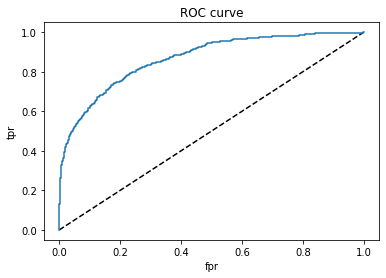

In [37]:
from sklearn.metrics import roc_curve
y_pred_proba = classifier.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

In [38]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_pred_proba)

0.8673125489471415

# Optimize the model (5 points)

In [0]:
normalizedclassifier = tf.keras.models.Sequential()
# Adding the input layer and the first hidden layer
normalizedclassifier.add(tf.keras.layers.Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 12))
normalizedclassifier.add(tf.keras.layers.BatchNormalization())
# Adding the second hidden layer
normalizedclassifier.add(tf.keras.layers.Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
normalizedclassifier.add(tf.keras.layers.Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN | means applying SGD on the whole ANN
normalizedclassifier.compile(optimizer = 'sgd', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [40]:
normalizedclassifier.fit(X_train, y_train, batch_size = 10, epochs = 100,verbose = 0,validation_data=(X_test, y_test))

In [41]:
normalizedclassifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 6)                 78        
_________________________________________________________________
batch_normalization (BatchNo (None, 6)                 24        
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 151
Trainable params: 139
Non-trainable params: 12
_________________________________________________________________


In [42]:
trainscore, trainacc = normalizedclassifier.evaluate(X_train, y_train, batch_size=10)
score, acc = normalizedclassifier.evaluate(X_test, y_test,batch_size=10)
y_pred = normalizedclassifier.predict(X_test)
y_pred = (y_pred > 0.5)

print('-'*100)

print('Train accuracy:', trainacc)
print('Test accuracy:', acc)


3000/3000 [==============================] - 0s 115us/sample - loss: 0.3414 - accuracy: 0.8583
----------------------------------------------------------------------------------------------------
Train accuracy: 0.8617143
Test accuracy: 0.85833335


In [43]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix :", "\n",cm )

Confusion Matrix : 
 [[2232  147]
 [ 278  343]]


In [44]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      2379
           1       0.70      0.55      0.62       621

    accuracy                           0.86      3000
   macro avg       0.79      0.75      0.77      3000
weighted avg       0.85      0.86      0.85      3000



Batch normalization has yielded the accuracy score of 85% and it didnt help in optimization

**Adding more hidden layers**

In [0]:
#Initialize Sequential model
model2 = tf.keras.models.Sequential()

# Keras declares weights and bias automatically
#input_dim is required for the first hidden layer, as it is the first starting point. --> number of inputs.
model2.add(tf.keras.layers.Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 12))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Dense(22, activation='relu'))
model2.add(tf.keras.layers.Dense(11, activation='relu'))

# Output Layer
# output_dim should be 1, as output is binary outcome, and activation should be 'sigmoid'
# Keras declares weights and bias automatically
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [46]:
X_train.shape

(7000, 12)

In [47]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model2.fit(X_train, y_train,epochs=500,batch_size = 32)

Train on 7000 samples
Epoch 1/500
7000/7000 [==============================] - 1s 146us/sample - loss: 0.5963 - accuracy: 0.7433
Epoch 2/500
7000/7000 [==============================] - 0s 65us/sample - loss: 0.5222 - accuracy: 0.7976
Epoch 3/500
7000/7000 [==============================] - 0s 68us/sample - loss: 0.4854 - accuracy: 0.7979
Epoch 4/500
7000/7000 [==============================] - 0s 66us/sample - loss: 0.4651 - accuracy: 0.7977
Epoch 5/500
7000/7000 [==============================] - 0s 66us/sample - loss: 0.4490 - accuracy: 0.7974
Epoch 6/500
7000/7000 [==============================] - 0s 68us/sample - loss: 0.4420 - accuracy: 0.7987
Epoch 7/500
7000/7000 [==============================] - 0s 64us/sample - loss: 0.4353 - accuracy: 0.8020
Epoch 8/500
7000/7000 [==============================] - 0s 64us/sample - loss: 0.4298 - accuracy: 0.8079
Epoch 9/500
7000/7000 [==============================] - 0s 64us/sample - loss: 0.4243 - accuracy: 0.8136
Epoch 10/500
7000/7000 

In [48]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 6)                 78        
_________________________________________________________________
batch_normalization_1 (Batch (None, 6)                 24        
_________________________________________________________________
dense_7 (Dense)              (None, 22)                154       
_________________________________________________________________
dense_8 (Dense)              (None, 11)                253       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 12        
Total params: 521
Trainable params: 509
Non-trainable params: 12
_________________________________________________________________


In [49]:
trainscore, trainacc = model2.evaluate(X_train, y_train)
score, acc = model2.evaluate(X_test, y_test)

y_pred = model2.predict(X_test)
y_pred = (y_pred > 0.5)

print('-'*100)

print('Train accuracy:', trainacc)
print('Test accuracy:', acc)


3000/3000 [==============================] - 0s 43us/sample - loss: 0.3277 - accuracy: 0.8617
----------------------------------------------------------------------------------------------------
Train accuracy: 0.8694286
Test accuracy: 0.8616667


In [50]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix :", "\n",cm )

Confusion Matrix : 
 [[2264  115]
 [ 300  321]]


In [51]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.95      0.92      2379
           1       0.74      0.52      0.61       621

    accuracy                           0.86      3000
   macro avg       0.81      0.73      0.76      3000
weighted avg       0.85      0.86      0.85      3000



As seen above the optimization of model using more hidden layers and adam optimizer with learning rate 0.0001 has yielded a accuracy rate of 86% ,though it is almost similar to the unoptimized model score,when we look at the precision for our class of interest 1(customers exited),it has improved to 73% which is significant for uneven class distributions

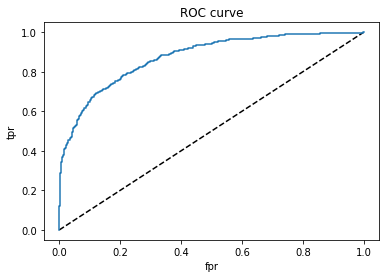

In [52]:
y_pred_proba = model2.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

In [53]:
roc_auc_score(y_test,y_pred_proba)

0.8746817801225023

The AUC has improved to 87% from 86, As our dataframe has uneven class distributions and our class of interest exited customers(1),has less number of data.

# Summary:

* Built a classifier that can determine whether they will leave or not using Neural networks.
* Analyzed the dataframe ,removed the unwanted columns, treated ouliers and splited target and feature sets from the data.
* Generated a neural networks classifier,with one input and one hidden layer and achieved an accuracy score of 86%
* Optimized the model by adding one more hidden layer,a batch normalization,batch size of 32,epochs 500 yielded a accuracy percent of 86%,Even though there is no improvement in the accuracy score,the precision and AUC has improved .